In [1371]:
import json
import requests
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # matplotlib is not installed automatically
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

from osgeo import gdal
import rioxarray
import rasterio as rio

import xarray as xr

In [1372]:
# network_name = 'various-geographic-locations'
# network_name = 'California'
network_name = 'various-geographic-locations2'
coordinate = 10

home_dir = r"G:\Araki\SMSigxSMAP"
input_path = r"1_data"
appeears_path = r"APPEEARS_subsetting"
SMAPL3_path = r"SPL3SMP_E"
SMAP_ANC_path = r"SMAP_L1_L3_ANC_STATIC"
SMAPL4_path = r"SPL4SMGP"
SMAPL4_grid_path = r"SMAPL4SMGP_EASEreference"
MODIS_path = r"MOD15A2H"
PET_path = r"PET"

output_path = r"3_data_out\exp_plots"

# succsss: ["Central_valley", "China (Mid-lat humid)", "South Dacota (Mid-lat dry)", "Argentina (Mid-lat dry)", "Russia (Mid-lat humid)"]
# ["Northern Australia 2", "Congo", "Canada", "South America", "Chile", "Argentina 2"]
# success: [0][4, 6, 8, 9][0, 2, 4, 5, 9, 10]

## Read and process data

### Request json

In [1373]:
file_path = os.path.join(home_dir, input_path, appeears_path, network_name, f'{network_name}-request.json')
with open(file_path, 'r') as infile:
    request_content = json.load(infile)

coordinates = request_content['params']['coordinates']
print(len(coordinates))
target_lat = coordinates[coordinate]['latitude']
target_lon = coordinates[coordinate]['longitude']
target_station = coordinates[coordinate]['category']
print(f'Currently processing station: {target_station}')

output_path2 = os.path.join(home_dir, output_path, target_station)
if not os.path.exists(output_path2):
    os.makedirs(output_path2)




11
Currently processing station: Argentina 2


### SMAP L3

In [1374]:
file_path = os.path.join(home_dir, input_path, appeears_path, network_name, f'{network_name}-SPL3SMP-E-005-results.csv')
SMAPL3_pt_sample = pd.read_csv(file_path)
SMAPL3_pt_sample = SMAPL3_pt_sample[(SMAPL3_pt_sample['Latitude'] == target_lat) & (SMAPL3_pt_sample['Longitude'] == target_lon)].copy()

df_ts_smap_am = SMAPL3_pt_sample[['Date', 'SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_soil_moisture','SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag']].copy()
df_ts_smap_am['Date'] = pd.to_datetime(df_ts_smap_am['Date'])
df_ts_smap_am.set_index('Date', inplace=True)
bad_data_idx_smap = df_ts_smap_am[(df_ts_smap_am['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag'] != 0.0) & (df_ts_smap_am['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag'] != 8.0)].index
df_ts_smap_am.drop(bad_data_idx_smap, inplace=True)
df_ts_smap_am_daily = df_ts_smap_am['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_soil_moisture'].resample('D', axis=0).mean()

df_ts_smap_pm = SMAPL3_pt_sample[['Date', 'SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm','SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm']].copy()
df_ts_smap_pm['Date'] = pd.to_datetime(df_ts_smap_pm['Date'])
df_ts_smap_pm.set_index('Date', inplace=True)
bad_data_idx_smap = df_ts_smap_pm[(df_ts_smap_pm['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm'] != 0.0) & (df_ts_smap_pm['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm'] != 8.0)].index
df_ts_smap_pm.drop(bad_data_idx_smap, inplace=True)
df_ts_smap_pm_daily = df_ts_smap_pm['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm'].resample('D', axis=0).mean()

df_ts_sync = pd.merge(df_ts_smap_am_daily, df_ts_smap_pm_daily, how='inner', left_index=True, right_index=True)
df_ts_sync['soil_moisture_smapL3'] = df_ts_sync[['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_soil_moisture','SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm']].mean(axis=1, skipna=True)
df_ts_sync['soil_moisture_smapL3'] = df_ts_sync['soil_moisture_smapL3'].resample('D', axis=0).mean()

### SMAPL4

In [1375]:
file_path = os.path.join(home_dir, input_path, appeears_path, network_name, f'{network_name}-P-SPL4SMGP-006-results.csv')
SMAPL4_pt_sample = pd.read_csv(file_path)
SMAPL4_pt_sample = SMAPL4_pt_sample[(SMAPL4_pt_sample['Latitude'] == target_lat) & (SMAPL4_pt_sample['Longitude'] == target_lon)].copy()

# print(SMAPL4_pt_sample.columns)

# SMAPL4_pt_sample[['SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_0', 
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_1',
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_2',
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_3',
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_4',
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_5',
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_6',
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_7']].plot()

# ? Where is data converted to daily from hourly? 

df_ts_smap_precip = SMAPL4_pt_sample[['Date', 'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_0']].copy()
df_ts_smap_precip = df_ts_smap_precip.rename({'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_0': 'precip'}, axis='columns')
df_ts_smap_precip['Date'] = pd.to_datetime(df_ts_smap_precip['Date'])
df_ts_smap_precip.set_index('Date', inplace=True)
df_ts_smap_precip


,precip
Date,
2015-03-31,1.000000e-07
2015-04-01,0.000000e+00
2015-04-02,1.000000e-07
2015-04-03,1.000000e-07
2015-04-04,0.000000e+00
...,...
2022-04-26,1.540000e-05
2022-04-27,1.000000e-07
2022-04-28,0.000000e+00


Convert precipitation from kg/m2/s to mm/day -> 1 kg/m2/s = 86400 mm/day

In [1376]:
df_ts_smap_precip = df_ts_smap_precip * 86400

In [1377]:
df_ts_sync = pd.merge(df_ts_sync, df_ts_smap_precip, how='inner', left_index=True, right_index=True)

noprecip = df_ts_smap_precip['precip'] < 0.00002
df_ts_sync['noprecip'] = noprecip

df_ts_sync.head()

,SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_soil_moisture,SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm,soil_moisture_smapL3,precip,noprecip
Date,,,,,
2015-04-01,0.105151,NaN,0.105151,0.00000,True
2015-04-02,NaN,0.048888,0.048888,0.00864,False
2015-04-03,0.086548,NaN,0.086548,0.00864,False
2015-04-04,NaN,NaN,NaN,0.00000,True
2015-04-05,0.065870,0.072245,0.069057,0.00000,True


In [1378]:
df_ts_sync.tail()

,SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_soil_moisture,SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm,soil_moisture_smapL3,precip,noprecip
Date,,,,,
2022-04-18,NaN,NaN,NaN,0.00000,True
2022-04-19,0.125079,0.111754,0.118416,0.00000,True
2022-04-20,0.115547,NaN,0.115547,0.00000,True
2022-04-21,NaN,NaN,NaN,0.01728,False
2022-04-22,NaN,0.123561,0.123561,0.00000,True


<Axes: xlabel='Date'>

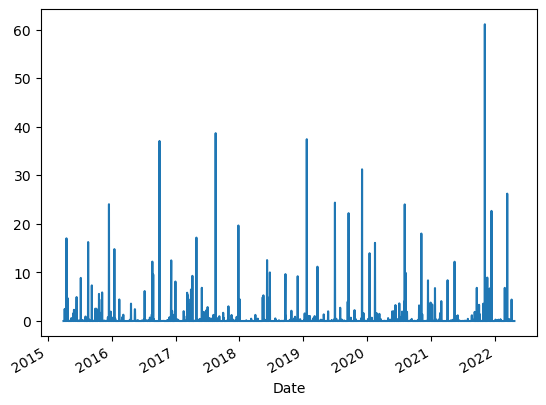

In [1379]:
df_ts_sync['precip'].plot()

### PET

Get the point-sampled PET data beforehand by running '0_code\singerPET_create_datarods_v3.py'

In [1380]:
file_path = os.path.join(home_dir, input_path, PET_path, target_station)
file_list = os.listdir(file_path)

print(file_list)
PET = pd.read_csv(os.path.join(file_path, file_list[0]), header=None)
day_num = PET.index.to_numpy()
year = file_list[0][-8:-4]
PET['Date'] = pd.to_datetime(PET.index, unit='D', origin=pd.Timestamp(year))
PET.set_index('Date', inplace=True)

for i, file in enumerate(file_list):
    PET = pd.read_csv(os.path.join(file_path, file), header=None)
    year = file[-8:-4]
    PET['Date'] = pd.to_datetime(PET.index, unit='D', origin=pd.Timestamp(year))
    PET.set_index('Date', inplace=True)
    if i==0:
        ds_PET = PET
    else:
        ds_PET = pd.concat([ds_PET, PET])
ds_PET = ds_PET.sort_index()
ds_PET = ds_PET.rename(columns = {0:'PET'})
ds_PET

['dPET_2015.txt', 'dPET_2016.txt', 'dPET_2017.txt', 'dPET_2018.txt', 'dPET_2019.txt', 'dPET_2020.txt', 'dPET_2021.txt']


,PET
Date,
2015-01-01,3.51240
2015-01-02,4.35791
2015-01-03,4.54099
2015-01-04,6.61272
2015-01-05,5.50878
...,...
2021-12-27,7.61253
2021-12-28,6.71320
2021-12-29,6.92435


In [1381]:
ds_synced = pd.merge(df_ts_sync[['soil_moisture_smapL3', 'precip']], ds_PET, how='inner', left_index=True, right_index=True)
ds_synced = ds_synced.rename({'soil_moisture_smapL3': 'soil_moisture_daily'}, axis='columns')
ds_synced

,soil_moisture_daily,precip,PET
Date,,,
2015-04-01,0.105151,0.00000,3.19059
2015-04-02,0.048888,0.00864,3.18328
2015-04-03,0.086548,0.00864,2.38956
2015-04-04,NaN,0.00000,2.24405
2015-04-05,0.069057,0.00000,2.06594
...,...,...,...
2021-12-27,NaN,0.00000,7.61253
2021-12-28,0.047529,0.00000,6.71320
2021-12-29,0.058846,0.00000,6.92435


### LAI

In [1382]:
MODIS_LAI_path = "MODIS_LAI"
file_path = os.path.join(home_dir, input_path, MODIS_LAI_path, network_name.replace(" ", "_"), f'daily_LAI_{target_station}.csv')
daily_LAI = pd.read_csv(file_path)
daily_LAI['Date'] = pd.to_datetime(daily_LAI.Date)
daily_LAI.set_index('Date', inplace=True)
daily_LAI.head()

,MODISmeanLAI_SMAPgrid
Date,
2015-03-30,0.109830
2015-03-31,0.108058
2015-04-01,0.106286
2015-04-02,0.104514
2015-04-03,0.102743


### NDVI

In [1383]:
MODIS_NDVI_path = "MODIS_NDVI"
file_path = os.path.join(home_dir, input_path, MODIS_NDVI_path, network_name.replace(" ", "_"), f'daily_NDVI_{target_station}.csv')
daily_NDVI = pd.read_csv(file_path)
daily_NDVI['Date'] = pd.to_datetime(daily_NDVI.Date)
daily_NDVI.set_index('Date', inplace=True)
daily_NDVI.head()

,MODISmeanNDVI_SMAPgrid
Date,
2015-03-22,0.174805
2015-03-23,0.175374
2015-03-24,0.175942
2015-03-25,0.176511
2015-03-26,0.177080


### Soil

In [1384]:
fn = r"G:\Araki\SMSigxSMAP\1_data\SMAPL4SMGP_EASEreference\SMAP_L4_SM_lmc_00000000T000000_Vv7032_001.h5"
EASEgrid_temp = xr.open_dataset(fn, engine='netcdf4')#.sel({'band':1})
EASEgrid_temp

<xarray.Dataset>
Dimensions:                  (phony_dim_2: 1, y: 1624, x: 3856)
Coordinates:
  * x                        (x) float64 -1.736e+07 -1.735e+07 ... 1.736e+07
  * y                        (y) float64 7.31e+06 7.301e+06 ... -7.31e+06
Dimensions without coordinates: phony_dim_2
Data variables:
    EASE2_global_projection  (phony_dim_2) |S1 ...
    cell_column              (y, x) float64 ...
    cell_lat                 (y, x) float32 ...
    cell_lon                 (y, x) float32 ...
    cell_row                 (y, x) float64 ...
    time                     (phony_dim_2) datetime64[ns] ...
Attributes:
    Source:       v17.11.1
    Institution:  NASA Global Modeling and Assimilation Office
    History:      File written by ldas2daac.x
    Comment:      HDF-5
    Filename:     /discover/nobackup/projects/gmao/smap/SMAP_L4/L4_SM/Vv7032/...
    Title:        SMAP L4_SM Land-Model-Constants (LMC) Data Granule
    Conventions:  CF
    References:   see SMAP L4_SM Product Specification Documentation
    Contact:      http://gmao.gsfc.nasa.gov

In [1385]:
def get_soil_prop(datatype="", target_lat=np.nan, target_lon=np.nan, plot_results=False): 
    file_path = os.path.join(home_dir, input_path, SMAP_ANC_path)
    soil_prop = np.fromfile(os.path.join(file_path, f'{datatype}_M09_004.float32'), dtype=np.float32)
    soil_prop_2d = soil_prop.reshape(EASEgrid_temp['cell_lat'].shape)
    da_soil_prop_2d = xr.DataArray(
        soil_prop_2d, 
        dims=("y", "x"),
        coords={
            'lat': (["y", "x"], np.squeeze(EASEgrid_temp.cell_lat.values)),
            'lon': (["y", "x"], np.squeeze(EASEgrid_temp.cell_lon.values)),
        }
    )
    da_soil_prop_2d.rio.write_crs('epsg:4326', inplace=True)
    if plot_results:
        da_soil_prop_2d.plot(vmin=0, x='lon', y='lat') #, ax=ax)

    lon_lat_pairs = np.column_stack((da_soil_prop_2d.lon.values.ravel(), da_soil_prop_2d.lat.values.ravel()))
    # lon_lat_pairs = np.column_stack((np.squeeze(EASEgrid_temp.cell_lon.values).ravel(), np.squeeze(EASEgrid_temp.cell_lat.values).ravel()))
    target_point = np.array([target_lon, target_lat])
    distances = np.linalg.norm(lon_lat_pairs - target_point, axis=1)
    distances = distances.reshape(da_soil_prop_2d.lon.shape)
    min_idx = np.unravel_index(np.argmin(distances), distances.shape)

    # Get the value of the pixel with the minimum distance
    soil_prop_value = da_soil_prop_2d[min_idx].values

    return soil_prop_value

In [1386]:
bulk_density = get_soil_prop(datatype="bulk", target_lat=target_lat, target_lon=target_lon, plot_results=False)
bulk_density

array(1.66, dtype=float32)

In [1387]:
clay_fraction = get_soil_prop(datatype="clay", target_lat=target_lat, target_lon=target_lon, plot_results=False)
clay_fraction

array(0.1, dtype=float32)

In [1388]:
sand_fraction = get_soil_prop(datatype="sand", target_lat=target_lat, target_lon=target_lon, plot_results=False)
sand_fraction

array(0.86, dtype=float32)

In [1389]:
ds_synced = pd.merge(ds_synced, daily_LAI, how='left', left_index=True, right_index=True)
ds_synced = pd.merge(ds_synced, daily_NDVI, how='left', left_index=True, right_index=True)
ds_synced = ds_synced.rename({'MODISmeanLAI_SMAPgrid': 'LAI', 'MODISmeanNDVI_SMAPgrid': 'NDVI'}, axis='columns')
ds_synced['bulk_density'] = bulk_density
ds_synced['clay_fraction'] = clay_fraction
ds_synced['sand_fraction'] = sand_fraction
ds_synced.head()

,soil_moisture_daily,precip,PET,LAI,NDVI,bulk_density,clay_fraction,sand_fraction
Date,,,,,,,,
2015-04-01,0.105151,0.00000,3.19059,0.106286,0.180130,1.66,0.1,0.86
2015-04-02,0.048888,0.00864,3.18328,0.104514,0.180518,1.66,0.1,0.86
2015-04-03,0.086548,0.00864,2.38956,0.102743,0.180906,1.66,0.1,0.86
2015-04-04,NaN,0.00000,2.24405,0.102631,0.181295,1.66,0.1,0.86
2015-04-05,0.069057,0.00000,2.06594,0.102519,0.181683,1.66,0.1,0.86


In [1390]:
ds_synced.tail()

,soil_moisture_daily,precip,PET,LAI,NDVI,bulk_density,clay_fraction,sand_fraction
Date,,,,,,,,
2021-12-27,NaN,0.0,7.61253,0.253273,0.218068,1.66,0.1,0.86
2021-12-28,0.047529,0.0,6.71320,0.249526,0.215313,1.66,0.1,0.86
2021-12-29,0.058846,0.0,6.92435,0.245779,0.212558,1.66,0.1,0.86
2021-12-30,0.045717,0.0,5.34628,0.242031,0.209803,1.66,0.1,0.86
2021-12-31,NaN,0.0,5.50586,0.238284,0.207048,1.66,0.1,0.86


## Calculate dSdt

In [1391]:
# Thresholds
lower_quantile_thresh = 0.25
upper_quantile_thresh = 0.75
precip_thresh = 0.00002

In [1392]:
precip_mask = ds_synced['precip'].where(ds_synced['precip'] < precip_thresh)
no_sm_record_but_precip_present = ds_synced['precip'].where((precip_mask.isnull()) & (ds_synced['soil_moisture_daily'].isnull()))
# ds_synced['sm_for_dS_calc'] = ds_synced['soil_moisture_daily'].where(no_sm_record_but_precip_present.isnull(), 9999)

# Allow detecting soil moisture increment even if there is no SM data in between before/after rainfall event
# NaN data is allowed up to 10 days
ds_synced['sm_for_dS_calc'] = ds_synced['soil_moisture_daily'].ffill() 

In [1393]:
# Calculate dS
ds_synced['dS'] = ds_synced['sm_for_dS_calc'].bfill(limit=5).diff().where(ds_synced['sm_for_dS_calc'].notnull().shift(periods=+1))

# Drop the dS where  (precipitation is present) && (soil moisture record does not exist)
ds_synced['dS'] = ds_synced['dS'].where((ds_synced['dS'] > -1) & (ds_synced['dS'] < 1))

# Calculate dt
non_nulls = ds_synced['sm_for_dS_calc'].isnull().cumsum()
nan_length = non_nulls.where(ds_synced['sm_for_dS_calc'].notnull()).bfill()+1 - non_nulls +1
ds_synced['dt'] = nan_length.where(ds_synced['sm_for_dS_calc'].isnull()).fillna(1)

# Calculate dS/dt
ds_synced['dSdt'] = ds_synced['dS']/ds_synced['dt']
ds_synced['dSdt'] = ds_synced['dSdt'].shift(periods=-1)


In [1394]:
ds_synced.loc[ds_synced['soil_moisture_daily'].shift(-1).isna(), 'dSdt'] = np.nan

In [1395]:
ds_synced.head()

,soil_moisture_daily,precip,PET,LAI,NDVI,bulk_density,clay_fraction,sand_fraction,sm_for_dS_calc,dS,dt,dSdt
Date,,,,,,,,,,,,
2015-04-01,0.105151,0.00000,3.19059,0.106286,0.180130,1.66,0.1,0.86,0.105151,NaN,1.0,-0.056263
2015-04-02,0.048888,0.00864,3.18328,0.104514,0.180518,1.66,0.1,0.86,0.048888,-0.056263,1.0,0.037660
2015-04-03,0.086548,0.00864,2.38956,0.102743,0.180906,1.66,0.1,0.86,0.086548,0.037660,1.0,NaN
2015-04-04,NaN,0.00000,2.24405,0.102631,0.181295,1.66,0.1,0.86,0.086548,0.000000,1.0,-0.017491
2015-04-05,0.069057,0.00000,2.06594,0.102519,0.181683,1.66,0.1,0.86,0.069057,-0.017491,1.0,-0.001389


## Detect significant peak

Adapt https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2017GL072819


- Any positive increment smaller than 5% of the observed range of soil moisture at the site is excluded if it would otherwise truncate a drydown. 
- To avoid noise creating spurious drydowns, identified drydowns were excluded from the analysis when the positive increment preceding the drydown was less than two times the target unbiased root-mean-square difference for SMAP observations (0.08). 
- Of the remaining drydowns, only those that contained more than four SMAP observations were retained.

In [1396]:
# Any positive increment smaller than 5% of the observed range of soil moisture at the site is excluded if it would otherwise truncate a drydown. 
dSdt_thresh = (ds_synced.soil_moisture_daily.max() - ds_synced.soil_moisture_daily.min()) * 0.05

# To avoid noise creating spurious drydowns, identified drydowns were excluded from the analysis when the positive increment preceding the drydown was less than two times the target unbiased root-mean-square difference for SMAP observations (0.08).
target_rmsd = 0.08
dSdt_thresh

0.01233517

In [1397]:
ds_synced.head(15)

,soil_moisture_daily,precip,PET,LAI,NDVI,bulk_density,clay_fraction,sand_fraction,sm_for_dS_calc,dS,dt,dSdt
Date,,,,,,,,,,,,
2015-04-01,0.105151,0.00000,3.19059,0.106286,0.180130,1.66,0.1,0.86,0.105151,NaN,1.0,-0.056263
2015-04-02,0.048888,0.00864,3.18328,0.104514,0.180518,1.66,0.1,0.86,0.048888,-0.056263,1.0,0.037660
2015-04-03,0.086548,0.00864,2.38956,0.102743,0.180906,1.66,0.1,0.86,0.086548,0.037660,1.0,NaN
2015-04-04,NaN,0.00000,2.24405,0.102631,0.181295,1.66,0.1,0.86,0.086548,0.000000,1.0,-0.017491
2015-04-05,0.069057,0.00000,2.06594,0.102519,0.181683,1.66,0.1,0.86,0.069057,-0.017491,1.0,-0.001389
2015-04-06,0.067668,0.00000,2.41926,0.102408,0.182071,1.66,0.1,0.86,0.067668,-0.001389,1.0,NaN
2015-04-07,NaN,0.00000,1.87029,0.102296,0.182459,1.66,0.1,0.86,0.067668,0.000000,1.0,NaN
2015-04-08,NaN,2.48832,2.12979,0.103303,0.183054,1.66,0.1,0.86,0.067668,0.000000,1.0,NaN
2015-04-09,NaN,0.00000,2.40257,0.104309,0.183649,1.66,0.1,0.86,0.067668,0.000000,1.0,NaN


In [1398]:
negative_increments = ds_synced.dSdt < 0

# To avoid noise creating spurious drydowns, identified drydowns were excluded from the analysis when the positive increment preceding the drydown was less than two times the target unbiased root-mean-square difference for SMAP observations (0.08).
positive_increments = ds_synced.dSdt > target_rmsd

In [1399]:

# positive_increments = ds_synced.dS.ffill() > target_rmsd
# TODO: NOT lose drydown starting after NaN

# Negative dSdt preceded with positive dSdt
ds_synced['event_start'] = negative_increments.values & np.concatenate(([False], positive_increments[:-1]))
ds_synced['event_start'][ds_synced['event_start']].index

# drydown_indices = ds_synced.index[negative_increments & pd.Series(np.concatenate(([False], positive_increments[:-1])), index=ds_synced.index)]
# drydown_indices
# sum(negative_increments.values & np.concatenate(([False], positive_increments[:-1])))

DatetimeIndex(['2015-06-05', '2016-08-26', '2017-07-04', '2017-10-30',
               '2017-12-26', '2018-05-15', '2018-07-10', '2020-08-21',
               '2020-09-14', '2021-11-18'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [1400]:
# # iterate through each row to find event end
# precip_thresh = 2
# event_end = np.zeros(ds_synced.shape[0], dtype=bool)
# ds_synced['dS'] = ds_synced['dS'].shift(-1)
# for i in range(1, ds_synced.shape[0]):
#     if ds_synced['event_start'][i]:
#         start_index = i
#         for j in range(i+1, ds_synced.shape[0]):
#             if np.isnan(ds_synced['dS'][j]):
#                 continue
#             if ds_synced['dS'][j] >= dSdt_thresh or ds_synced['precip'][j] > precip_thresh:
#                 event_end[j] = True
#                 break

# # create a new column for event_end
# ds_synced['event_end'] = event_end
# iterate through each row to find event end
precip_thresh = 2
event_end = np.zeros(ds_synced.shape[0], dtype=bool)
# ds_synced['dS'] = ds_synced['dS'].shift(-1)
for i in range(1, ds_synced.shape[0]):
    if ds_synced['event_start'][i]:
        start_index = i
        for j in range(i+1, ds_synced.shape[0]):
            if np.isnan(ds_synced['dS'][j]):
                None
            if ds_synced['dS'][j] >= dSdt_thresh or ds_synced['precip'][j] > precip_thresh:
                # Any positive increment smaller than 5% of the observed range of soil moisture at the site is excluded (if there is not precipitation) if it would otherwise truncate a drydown. 
                event_end[j] = True
                break

# create a new column for event_end
ds_synced['event_end'] = event_end
ds_synced['event_end'] = ds_synced['event_end'].shift(-1)
ds_synced = ds_synced[:-1]

In [1401]:
ds_synced['event_start'][ds_synced['event_start']].index

DatetimeIndex(['2015-06-05', '2016-08-26', '2017-07-04', '2017-10-30',
               '2017-12-26', '2018-05-15', '2018-07-10', '2020-08-21',
               '2020-09-14', '2021-11-18'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [1402]:
ds_synced['event_start'][ds_synced['event_end']].index

DatetimeIndex(['2015-06-13', '2016-09-06', '2017-07-23', '2017-10-31',
               '2018-01-01', '2018-05-17', '2018-07-12', '2020-08-26',
               '2020-09-27', '2021-11-22'],
              dtype='datetime64[ns]', name='Date', freq=None)

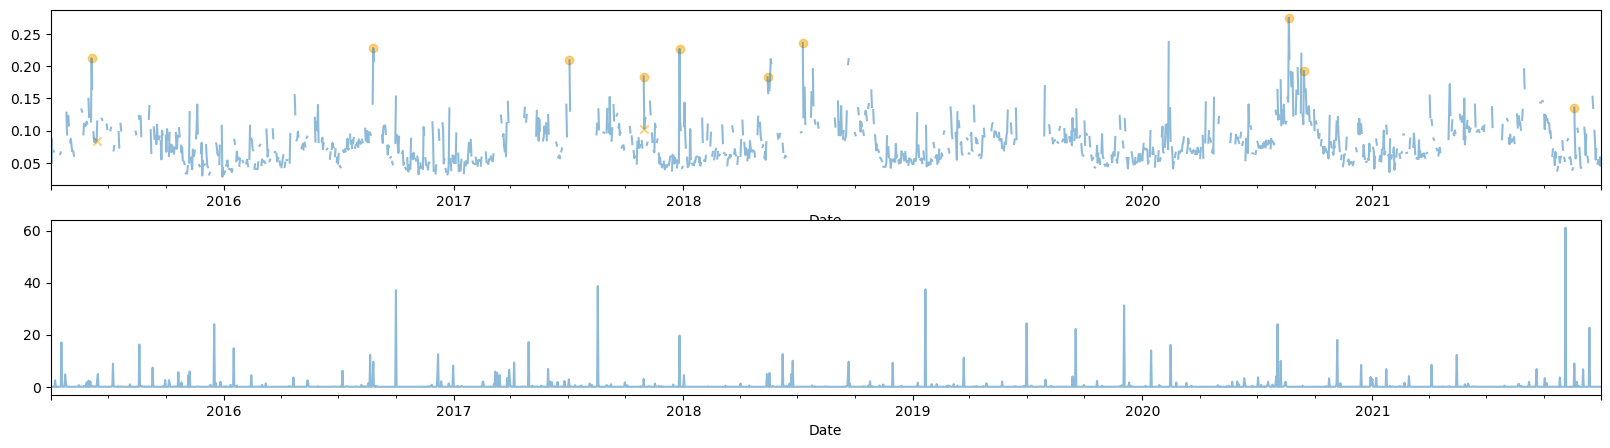

In [1403]:
fig, (ax11, ax12) = plt.subplots(2,1, figsize=(20, 5))
ds_synced.soil_moisture_daily.plot(ax=ax11, alpha=0.5)
ax11.scatter(ds_synced.soil_moisture_daily[ds_synced['event_start']].index, ds_synced.soil_moisture_daily[ds_synced['event_start']].values, color='orange', alpha=0.5)
ax11.scatter(ds_synced.soil_moisture_daily[ds_synced['event_end']].index, ds_synced.soil_moisture_daily[ds_synced['event_end']].values, color='orange', marker='x', alpha=0.5)
ds_synced.precip.plot(ax=ax12, alpha=0.5)
fig.savefig(os.path.join(output_path2, f'{target_station}_timeseries.png'))


(17897.0, 18260.0)

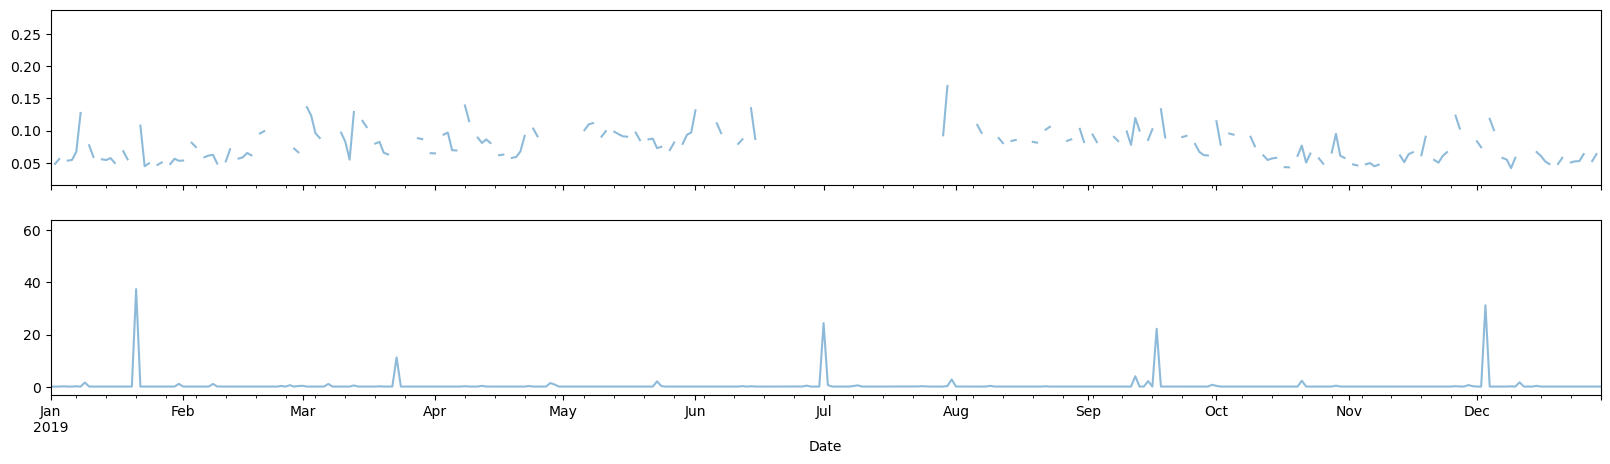

In [1404]:
fig2, (ax21, ax22) = plt.subplots(2,1, figsize=(20, 5), sharex=True)
ds_synced.soil_moisture_daily.plot(ax=ax21, alpha=0.5)
ax21.scatter(ds_synced.soil_moisture_daily[ds_synced['event_start']].index, ds_synced.soil_moisture_daily[ds_synced['event_start']].values, color='orange', alpha=0.5)
ax21.scatter(ds_synced.soil_moisture_daily[ds_synced['event_end']].index, ds_synced.soil_moisture_daily[ds_synced['event_end']].values, color='orange', marker='x', alpha=0.5)
ds_synced.precip.plot(ax=ax22, alpha=0.5)
ax22.set_xlim([datetime(2019, 1, 1), datetime(2019, 12, 30)])

In [1405]:
ds_synced['dSdt(t-1)'] = ds_synced.dSdt.shift(+1)
ds_synced.head(10)

,soil_moisture_daily,precip,PET,LAI,NDVI,bulk_density,clay_fraction,sand_fraction,sm_for_dS_calc,dS,dt,dSdt,event_start,event_end,dSdt(t-1)
Date,,,,,,,,,,,,,,,
2015-04-01,0.105151,0.00000,3.19059,0.106286,0.180130,1.66,0.1,0.86,0.105151,NaN,1.0,-0.056263,False,False,NaN
2015-04-02,0.048888,0.00864,3.18328,0.104514,0.180518,1.66,0.1,0.86,0.048888,-0.056263,1.0,0.037660,False,False,-0.056263
2015-04-03,0.086548,0.00864,2.38956,0.102743,0.180906,1.66,0.1,0.86,0.086548,0.037660,1.0,NaN,False,False,0.037660
2015-04-04,NaN,0.00000,2.24405,0.102631,0.181295,1.66,0.1,0.86,0.086548,0.000000,1.0,-0.017491,False,False,NaN
2015-04-05,0.069057,0.00000,2.06594,0.102519,0.181683,1.66,0.1,0.86,0.069057,-0.017491,1.0,-0.001389,False,False,-0.017491
2015-04-06,0.067668,0.00000,2.41926,0.102408,0.182071,1.66,0.1,0.86,0.067668,-0.001389,1.0,NaN,False,False,-0.001389
2015-04-07,NaN,0.00000,1.87029,0.102296,0.182459,1.66,0.1,0.86,0.067668,0.000000,1.0,NaN,False,False,NaN
2015-04-08,NaN,2.48832,2.12979,0.103303,0.183054,1.66,0.1,0.86,0.067668,0.000000,1.0,NaN,False,False,NaN
2015-04-09,NaN,0.00000,2.40257,0.104309,0.183649,1.66,0.1,0.86,0.067668,0.000000,1.0,NaN,False,False,NaN


## Separate into events

In [1406]:
start_indices = ds_synced[ds_synced['event_start']].index
end_indices = ds_synced[ds_synced['event_end']].index

# Create a new DataFrame with each row containing a list of soil moisture values between each pair of event_start and event_end
event_data = [{'event_start': start_index, 
               'event_end': end_index, 
               'soil_moisture_daily': list(ds_synced.loc[start_index:end_index, 'soil_moisture_daily'].values),
               'precip': list(ds_synced.loc[start_index:end_index, 'precip'].values),
               'PET': list(ds_synced.loc[start_index:end_index, 'PET'].values),
               'LAI': list(ds_synced.loc[start_index:end_index, 'LAI'].values),
               'NDVI': list(ds_synced.loc[start_index:end_index, 'NDVI'].values),
               'delta_theta': ds_synced.loc[start_index, 'dSdt(t-1)'],
                'bulk_density': ds_synced.loc[start_index, 'bulk_density'],
                'sand_fraction': ds_synced.loc[start_index, 'sand_fraction'],
                'clay_fraction': ds_synced.loc[start_index, 'clay_fraction']
               } 
               for start_index, end_index in zip(start_indices, end_indices)]
event_df = pd.DataFrame(event_data)

In [1407]:
event_df_long = event_df[event_df['soil_moisture_daily'].apply(lambda x: pd.notna(x).sum()) >= 4].copy()
event_df_long = event_df_long.reset_index(drop=True)
event_df_long


,event_start,event_end,soil_moisture_daily,precip,PET,LAI,NDVI,delta_theta,bulk_density,sand_fraction,clay_fraction
0,2015-06-05,2015-06-13,"[0.2122684, 0.16523100000000002, nan, 0.097817...","[0.00864, 0.31968, 0.20736, 0.0, 0.0, 0.16416,...","[0.04938, 0.10192, 0.17278, 0.20402, 0.28469, ...","[0.0514370565255521, 0.0072072072072072, 0.007...","[0.1932362023693209, 0.1972388495359062, 0.201...",0.098066,1.66,0.86,0.1
1,2016-08-26,2016-09-06,"[0.2281945, 0.20836475, nan, nan, nan, nan, 0....","[9.58176, 0.06048, 0.0, 0.0, 0.37152, 0.0, 0.0...","[0.32148, 0.67102, 1.42673, 1.50746, 1.74922, ...","[0.1011839272901219, 0.1012098381567408, 0.101...","[0.1736845885267137, 0.1730091164324158, 0.172...",0.086462,1.66,0.86,0.1
2,2017-07-04,2017-07-23,"[0.2092885, 0.1310275, nan, nan, nan, nan, nan...","[0.01728, 0.0, 0.16416, 0.0, 0.0, 0.00864, 0.0...","[0.63238, 0.53614, 0.78004, 0.44515, 0.99515, ...","[0.5420712748146377, 0.5431077094793909, 0.544...","[0.1748333333333333, 0.1790231705450091, 0.183...",0.118034,1.66,0.86,0.1
3,2017-12-26,2018-01-01,"[0.2269802, 0.1160083, 0.1009504, nan, 0.04213...","[19.673280000000002, 0.02592, 0.0, 0.0, 0.0, 0...","[3.93009, 3.27392, 6.51576, 5.92315, 5.05431, ...","[0.2356573387546839, 0.2441840070158654, 0.245...","[0.2148204613340538, 0.2155297598078462, 0.212...",0.176314,1.66,0.86,0.1
4,2020-08-21,2020-08-26,"[0.2752956, 0.2121269, nan, 0.19127885, 0.1688...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.1311, 0.9754, 0.60029, 0.55059, 0.51382, 0....","[0.0058159929841345, 0.0090967073267958, 0.012...","[0.1375874084875738, 0.1371078526894334, 0.136...",0.130421,1.66,0.86,0.1
5,2020-09-14,2020-09-27,"[0.1927996, 0.1604226, nan, 0.1638298000000000...","[0.0, 0.0, 0.0, 0.0, 0.02592, 0.0, 0.0, 0.0, 0...","[2.78437, 2.1095, 1.89647, 2.66185, 2.16844, 2...","[0.099940205692418, 0.0999760822769672, 0.1000...","[0.1604097865690996, 0.162249957658983, 0.1640...",0.082844,1.66,0.86,0.1
6,2021-11-18,2021-11-22,"[0.13586975, 0.0848987, 0.056951, 0.06097, nan]","[8.9424, 0.0, 0.0, 0.0, 1.9008]","[5.16325, 5.15637, 4.66411, 2.6709, 3.52238]","[0.1682093598022802, 0.1824922267400144, 0.196...","[0.2058983834979319, 0.2068698832155318, 0.207...",0.093991,1.66,0.86,0.1


## Calculate tau

In [1408]:
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.optimize import minimize

In [1409]:
# Function for exponential model
def exp_model(t, delta_theta, theta_w, tau):
    return delta_theta * np.exp(-t/tau) + theta_w

def neg_log_likelihood(params, t, y):
    delta_theta, theta_w, tau, sigma = params
    y_hat = exp_model(t, delta_theta, theta_w, tau)
    residuals = y - y_hat
    ssr = np.sum(residuals ** 2)
    n = len(y)
    sigma2 = ssr / n
    ll = -(n / 2) * np.log(2 * np.pi * sigma2) - (1 / (2 * sigma2)) * ssr
    return -ll


In [1410]:
min_sm_values_at_the_pt = df_ts_sync.soil_moisture_smapL3.min()
min_sm_values_at_the_pt

0.0285922

In [1411]:
# Fit exponential model to each drydown event

opt_model = 'OLSE'
# opt_model = 'MLE'
drydown_params = []
for index, row in event_df_long.iterrows():
    start_date = row['event_start']
    end_date = row['event_end']
    delta_theta = row['delta_theta']
    soil_moisture_subset = np.asarray(row['soil_moisture_daily'])
    t = np.arange(0, len(soil_moisture_subset),1)
    soil_moisture_range = np.nanmax(soil_moisture_subset) - np.nanmin(soil_moisture_subset)
    soil_moisture_subset_min = np.nanmin(soil_moisture_subset)
    soil_moisture_subset_max = np.nanmax(soil_moisture_subset)
    x = t[~np.isnan(soil_moisture_subset)]
    y = soil_moisture_subset[~np.isnan(soil_moisture_subset)]
    #       delta_theta, theta_w, tau, sigma
    
    if opt_model == "MLE":
        bounds  = ((0, 2*soil_moisture_range), (min_sm_values_at_the_pt, soil_moisture_subset_min), (0, np.inf), (0, np.inf))
        p0      = [0.5*soil_moisture_subset_max, (min_sm_values_at_the_pt+soil_moisture_subset_min)/2, 1, 0.1]
        res = minimize(neg_log_likelihood, p0, args=(t[~np.isnan(soil_moisture_subset)], soil_moisture_subset[~np.isnan(soil_moisture_subset)]), bounds=bounds, method='L-BFGS-B')
        popt = res.x
        if res.success and res.fun < 0:
            drydown_params.append({'event_start': start_date, 'event_end': end_date, 'delta_theta': popt[0], 'theta_w': popt[1], 'tau': popt[2]})
    elif opt_model == 'OLSE':
        # exp_model(t, delta_theta, theta_w, tau):
        bounds  = [(0, min_sm_values_at_the_pt, 0), (2*soil_moisture_range, soil_moisture_subset_min, np.inf)]
        p0      = [0.5*soil_moisture_range, (soil_moisture_subset_min+min_sm_values_at_the_pt)/2, 1]
        try: 
            popt, pcov = curve_fit(f=exp_model, xdata=x, ydata=y, p0=p0, bounds=bounds)
            # popt: Optimal values for the parameters so that the sum of the squared residuals of f(xdata, *popt) - ydata is minimized
            # pcov: The estimated covariance of popt
            y_opt = exp_model(x, *popt)
            residuals = y - y_opt
            ss_res = np.sum(residuals ** 2)
            ss_tot = np.sum((y - np.nanmean(y)) ** 2)
            r_squared = 1 - (ss_res / ss_tot)

            drydown_params.append({'event_start': start_date, 'event_end': end_date, 'delta_theta': popt[0], 'theta_w': popt[1], 'tau': popt[2], 'r_squared': r_squared, 'opt_drydown': y_opt.tolist()})
        except:
            print('Error raised')
            continue

# Convert drydown parameters to DataFrame
drydown_params_df = pd.DataFrame(drydown_params)
drydown_params


[{'event_start': Timestamp('2015-06-05 00:00:00'),
  'event_end': Timestamp('2015-06-13 00:00:00'),
  'delta_theta': 0.1369390984463028,
  'theta_w': 0.07911939219112926,
  'tau': 1.7105361477255374,
  'r_squared': 0.9834187457750025,
  'opt_drydown': [0.21605849063743207,
   0.1554385708886053,
   0.10282472929711703,
   0.09233089919827675,
   0.08322299016777923,
   0.08140641781665109,
   0.08039400199490528]},
 {'event_start': Timestamp('2016-08-26 00:00:00'),
  'event_end': Timestamp('2016-09-06 00:00:00'),
  'delta_theta': 0.16941445726541174,
  'theta_w': 0.06473579524550911,
  'tau': 4.271038825096709,
  'r_squared': 0.9837954125191098,
  'opt_drydown': [0.23415025251092086,
   0.19878581961924424,
   0.1063124017897091,
   0.08533252757321504]},
 {'event_start': Timestamp('2017-07-04 00:00:00'),
  'event_end': Timestamp('2017-07-23 00:00:00'),
  'delta_theta': 0.09478450005711186,
  'theta_w': 0.11450399984658657,
  'tau': 0.572468095724657,
  'r_squared': 0.9784585914066994,

In [1412]:
event_df_with_curvefit = pd.merge(event_df_long, drydown_params_df.drop(columns='delta_theta'), on=['event_start', 'event_end'], how='outer')
event_df_with_curvefit

,event_start,event_end,soil_moisture_daily,precip,PET,LAI,NDVI,delta_theta,bulk_density,sand_fraction,clay_fraction,theta_w,tau,r_squared,opt_drydown
0,2015-06-05,2015-06-13,"[0.2122684, 0.16523100000000002, nan, 0.097817...","[0.00864, 0.31968, 0.20736, 0.0, 0.0, 0.16416,...","[0.04938, 0.10192, 0.17278, 0.20402, 0.28469, ...","[0.0514370565255521, 0.0072072072072072, 0.007...","[0.1932362023693209, 0.1972388495359062, 0.201...",0.098066,1.66,0.86,0.1,0.079119,1.710536,0.983419,"[0.21605849063743207, 0.1554385708886053, 0.10..."
1,2016-08-26,2016-09-06,"[0.2281945, 0.20836475, nan, nan, nan, nan, 0....","[9.58176, 0.06048, 0.0, 0.0, 0.37152, 0.0, 0.0...","[0.32148, 0.67102, 1.42673, 1.50746, 1.74922, ...","[0.1011839272901219, 0.1012098381567408, 0.101...","[0.1736845885267137, 0.1730091164324158, 0.172...",0.086462,1.66,0.86,0.1,0.064736,4.271039,0.983795,"[0.23415025251092086, 0.19878581961924424, 0.1..."
2,2017-07-04,2017-07-23,"[0.2092885, 0.1310275, nan, nan, nan, nan, nan...","[0.01728, 0.0, 0.16416, 0.0, 0.0, 0.00864, 0.0...","[0.63238, 0.53614, 0.78004, 0.44515, 0.99515, ...","[0.5420712748146377, 0.5431077094793909, 0.544...","[0.1748333333333333, 0.1790231705450091, 0.183...",0.118034,1.66,0.86,0.1,0.114504,0.572468,0.978459,"[0.20928849990369844, 0.1310275006166019, 0.11..."
3,2017-12-26,2018-01-01,"[0.2269802, 0.1160083, 0.1009504, nan, 0.04213...","[19.673280000000002, 0.02592, 0.0, 0.0, 0.0, 0...","[3.93009, 3.27392, 6.51576, 5.92315, 5.05431, ...","[0.2356573387546839, 0.2441840070158654, 0.245...","[0.2148204613340538, 0.2155297598078462, 0.212...",0.176314,1.66,0.86,0.1,0.037866,1.423861,0.975415,"[0.22390244766615103, 0.13003548503117168, 0.0..."
4,2020-08-21,2020-08-26,"[0.2752956, 0.2121269, nan, 0.19127885, 0.1688...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.1311, 0.9754, 0.60029, 0.55059, 0.51382, 0....","[0.0058159929841345, 0.0090967073267958, 0.012...","[0.1375874084875738, 0.1371078526894334, 0.136...",0.130421,1.66,0.86,0.1,0.168802,1.315135,0.968489,"[0.27360793129799055, 0.21779762917664322, 0.1..."
5,2020-09-14,2020-09-27,"[0.1927996, 0.1604226, nan, 0.1638298000000000...","[0.0, 0.0, 0.0, 0.0, 0.02592, 0.0, 0.0, 0.0, 0...","[2.78437, 2.1095, 1.89647, 2.66185, 2.16844, 2...","[0.099940205692418, 0.0999760822769672, 0.1000...","[0.1604097865690996, 0.162249957658983, 0.1640...",0.082844,1.66,0.86,0.1,0.106543,5.099655,0.847934,"[0.1859954705847388, 0.1718478853977255, 0.150..."
6,2021-11-18,2021-11-22,"[0.13586975, 0.0848987, 0.056951, 0.06097, nan]","[8.9424, 0.0, 0.0, 0.0, 1.9008]","[5.16325, 5.15637, 4.66411, 2.6709, 3.52238]","[0.1682093598022802, 0.1824922267400144, 0.196...","[0.2058983834979319, 0.2068698832155318, 0.207...",0.093991,1.66,0.86,0.1,0.053921,0.924537,0.983380,"[0.13631097560210784, 0.08185481590520055, 0.0..."


## Plot

In [1413]:
row

event_start                                          2021-11-18 00:00:00
event_end                                            2021-11-22 00:00:00
soil_moisture_daily      [0.13586975, 0.0848987, 0.056951, 0.06097, nan]
precip                                   [8.9424, 0.0, 0.0, 0.0, 1.9008]
PET                         [5.16325, 5.15637, 4.66411, 2.6709, 3.52238]
LAI                    [0.1682093598022802, 0.1824922267400144, 0.196...
NDVI                   [0.2058983834979319, 0.2068698832155318, 0.207...
delta_theta                                                     0.093991
bulk_density                                                        1.66
sand_fraction                                                       0.86
clay_fraction                                                        0.1
Name: 6, dtype: object

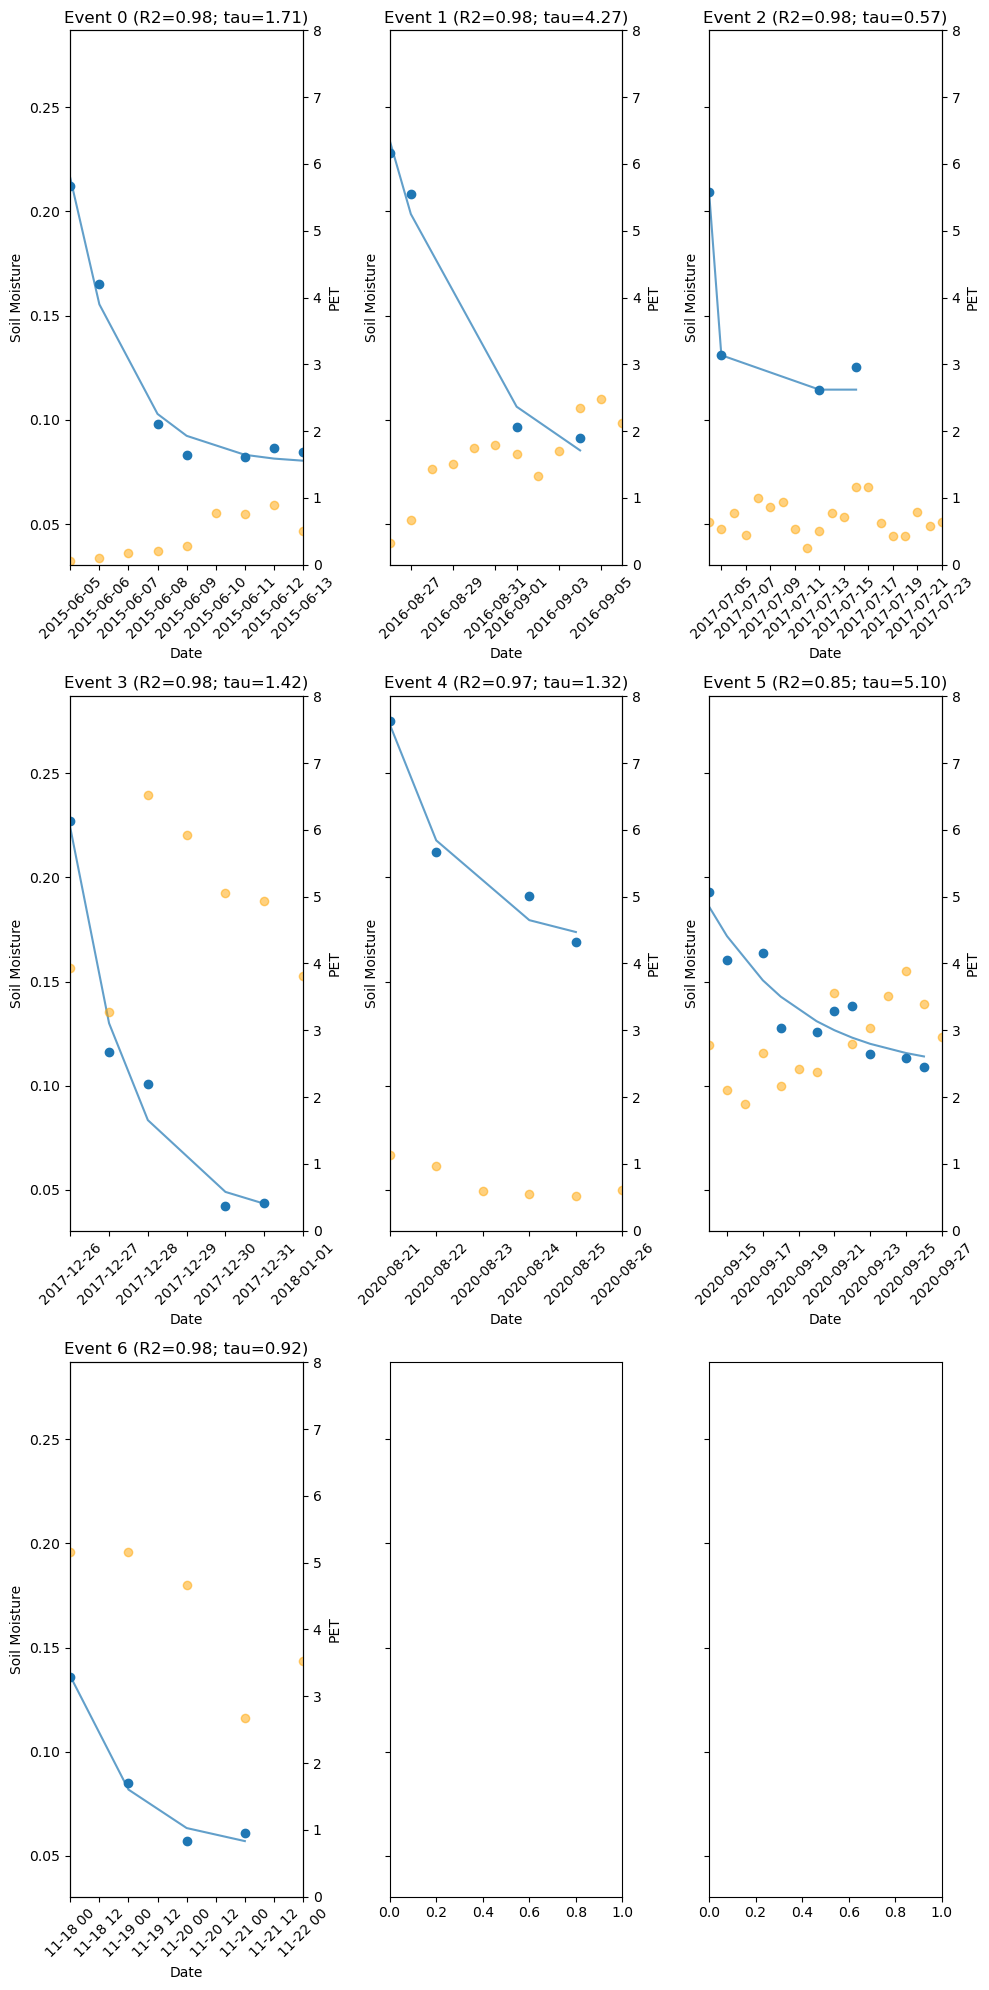

In [1414]:
# Convert the event start/end columns to datetime format
event_df_with_curvefit['event_start'] = pd.to_datetime(event_df_long['event_start'])
event_df_with_curvefit['event_end'] = pd.to_datetime(event_df_long['event_end'])

# Determine the number of columns needed for the subplots grid
num_events = len(event_df_with_curvefit)
num_cols = 3
num_rows = int(num_events / num_cols) + int(num_events % num_cols != 0)

# Plot each row of the event DataFrame as a time series
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, sharey=True, figsize=(10, 20))
for index, row in event_df_with_curvefit.iterrows():

    x = pd.date_range(start=row['event_start'], end=row['event_end'], freq='D')
    y = np.asarray(row['soil_moisture_daily'])
    y_opt = np.asarray(row['opt_drydown'])
    y2 = row['PET']
    t = np.arange(0, len(row['soil_moisture_daily']),1)
    r_squared = row['r_squared']
    tau = row['tau']
    try:
        ax_row = int(index / num_cols)
        ax_col = index % num_cols
        axes[ax_row, ax_col].scatter(x, y)
        axes[ax_row, ax_col].plot(x[~np.isnan(y)], y_opt, alpha=.7)
        ax2 = axes[ax_row, ax_col].twinx()
        ax2.scatter(x, y2, color='orange', alpha=.5)
        axes[ax_row, ax_col].set_title(f'Event {index} (R2={r_squared:.2f}; tau={tau:.2f})')
        axes[ax_row, ax_col].set_xlabel('Date')
        axes[ax_row, ax_col].set_ylabel('Soil Moisture')
        axes[ax_row, ax_col].set_xlim([row['event_start'], row['event_end']])
        ax2.set_ylim([0, 8])
        ax2.set_ylabel('PET')
        # Rotate the x tick labels
        axes[ax_row, ax_col].tick_params(axis='x', rotation=45)
    except:
        continue

fig.tight_layout()
fig.show()
fig.savefig(os.path.join(output_path2, f'{target_station}_events.png'))


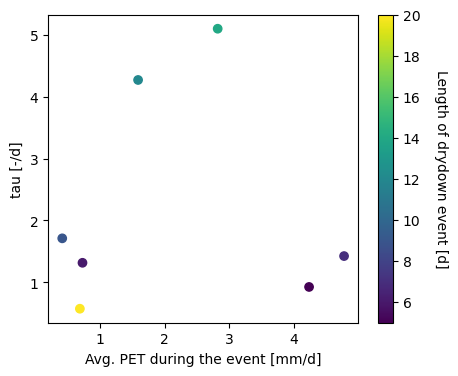

In [1415]:
event_df_with_curvefit['mean_PET'] = event_df_with_curvefit['PET'].apply(np.mean)
event_df_with_curvefit['event_length'] = event_df_with_curvefit['PET'].apply(len)
fig, ax = plt.subplots(1,1, figsize=(5, 4))
sc = ax.scatter(event_df_with_curvefit['mean_PET'], event_df_with_curvefit['tau'], c=event_df_with_curvefit['event_length'])
ax.set_xlabel('Avg. PET during the event [mm/d]')
ax.set_ylabel('tau [-/d]')
cbar = fig.colorbar(sc)
cbar.ax.set_ylabel('Length of drydown event [d]', rotation=270, labelpad=20)
fig.savefig(os.path.join(output_path2, f'{target_station}_tau_vs_PET.png'))

In [1416]:
event_df_with_curvefit.to_csv(os.path.join(home_dir, output_path2, 'event_df_with_curvefit.csv'), index=True)

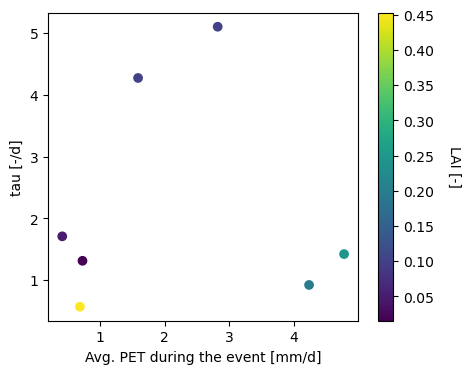

In [1417]:
event_df_with_curvefit['mean_LAI'] = event_df_with_curvefit['LAI'].apply(np.mean)
event_df_with_curvefit['event_length'] = event_df_with_curvefit['PET'].apply(len)
fig, ax = plt.subplots(1,1, figsize=(5, 4))
sc = ax.scatter(event_df_with_curvefit['mean_PET'], event_df_with_curvefit['tau'], c=event_df_with_curvefit['mean_LAI'])
ax.set_xlabel('Avg. PET during the event [mm/d]')
ax.set_ylabel('tau [-/d]')
cbar = fig.colorbar(sc)
cbar.ax.set_ylabel('LAI [-]', rotation=270, labelpad=20)
fig.savefig(os.path.join(output_path2, f'{target_station}_tau_vs_PET_vs_LAI.png'))

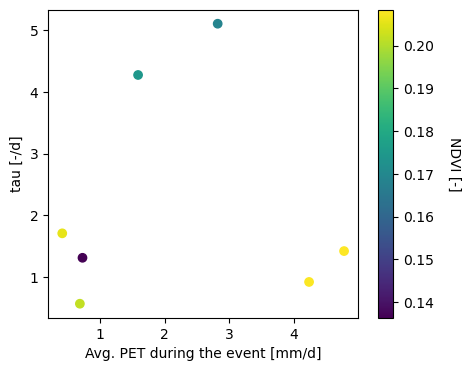

In [1418]:
event_df_with_curvefit['mean_NDVI'] = event_df_with_curvefit['NDVI'].apply(np.mean)
event_df_with_curvefit['event_length'] = event_df_with_curvefit['PET'].apply(len)
fig, ax = plt.subplots(1,1, figsize=(5, 4))
sc = ax.scatter(event_df_with_curvefit['mean_PET'], event_df_with_curvefit['tau'], c=event_df_with_curvefit['mean_NDVI'])
ax.set_xlabel('Avg. PET during the event [mm/d]')
ax.set_ylabel('tau [-/d]')
cbar = fig.colorbar(sc)
cbar.ax.set_ylabel('NDVI [-]', rotation=270, labelpad=20)
fig.savefig(os.path.join(output_path2, f'{target_station}_tau_vs_PET_vs_NDVI.png'))